In [1]:
from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import tensorflow
from tensorflow.keras import models, layers, utils, backend as K

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, Conv1D, MaxPooling1D, GRU, Softmax
from keras.utils import np_utils

import tensorflow_ranking as tfr

In [2]:
#Evaluation metrices that has to be used (objectives of project): accuracy, Average F1-score 
# ToDO: and Mean Average Precision (code provided on moodle) - needs to be added

# define metrics
def Recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def Precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def F1(y_true, y_pred):
    precision = Precision(y_true, y_pred)
    recall = Recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#taken from moodle
def computeMeanAveragePrecision(labels,softmaxEstimations):

    nbExamples , nbClasses = softmaxEstimations.shape

    averagePrecisions = np.zeros((nbClasses),dtype=np.float32)

    # For all classes
    for classIdx in range(nbClasses):

        # Sort the softmaxEstimations by decreasing order, and keep the order consistent with the labels
        permutation = list(reversed(np.argsort(softmaxEstimations[:,classIdx])))
        labelArray = np.asarray(labels)
        labelsTmp = list(labelArray[permutation])

        # Convert the labels to binary (1-vs-all)
        for idx in range(len(labelsTmp)):
            if labelsTmp[idx] == classIdx:
                labelsTmp[idx] = 1
            else:
                labelsTmp[idx] = 0

        # Compute the averaged sum of precisions by descending order
        nbPrecisionComputations = 0
        averagePrecisionSum = 0

        for idx in range(len(labelsTmp)):
            if labelsTmp[idx] == 1:
                averagePrecisionSum += np.sum(labelsTmp[:idx+1])/float(idx+1)
                nbPrecisionComputations += 1

        if nbPrecisionComputations == 0:
             averagePrecisions[classIdx] = 0
        else:
            averagePrecisions[classIdx] = averagePrecisionSum/float(nbPrecisionComputations)

    # Return global MAP and class MAPs
    return np.mean(averagePrecisions), averagePrecisions



In [3]:
#labels
#LABELS = ['Standing',
#          'Sitting',
#          'Lying',
#          'Squatting',
#          'Walking',
#          'Bending']

# dictionary of labels
labeldict = {
0 : "Bring",
1 : "Clean Floor",
2 : "Clean Surface",
4 : "Close Door",
5 : "Close Drawer",
6 : "Close Lid By Rotate",
7 : "Close Other Lid",
8 : "Close Small Box",
9 : "Close Tap Water",
10 : "Drink",
11 : "Dry Off Hands",
12 : "Dry Off Hands By Shake",
13 : "Eat Small",
14 : "Gargle",
15 : "Getting Up",
16 : "Hang",
17 : "Lying Down",
18 : "Open Bag",
19 : "Open Big Box",
20 : "Open Door",
21 : "Open Drawer",
22 : "Open Lid By Rotate",
23 : "Open Other Lid",
24 : "Open Small Box",
25 : "Open Tap Water",
26 : "Plug In",
27 : "Press by Grasp",
28 : "Press From Top",
29 : "Press Switch",
30 : "Put From Bottle",
31 : "Put From Tap Water",
32 : "Put High Position",
33 : "Put On Floor",
34 : "Read",
35 : "Rotate",
36 : "Rub Hands",
37 : "Scoop And Put",
38 : "Sitting Down",
39 : "Squatting Down",
40 : "Standing Up",
41 : "Stand Up From Squatting",
42 : "Take From Floor",
43 : "Take From High Position",
44 : "Take Off Jacket",
45 : "Take Out",
46 : "Talk By Telephone",
47 : "Throw Out",
48 : "Throw Out Water",
49 : "Touch Smartphone Screen",
50 : "Type",
51 : "Unhang",
52 : "Unplug",
53 : "Wear Jacket",
54 : "Write"
}
print('done')

done


In [4]:
# load data
# training
train_acc = np.load('../data/training/trainAccelerometer.npy')
train_gra = np.load('../data/training/trainGravity.npy')
train_gyr = np.load('../data/training/trainGyroscope.npy')
train_lin = np.load('../data/training/trainLinearAcceleration.npy')

train_mag = np.load('../data/training/trainMagnetometer800.npy')

trainJins_acc = np.load('../data/training/trainJinsAccelerometer800.npy')
trainJins_gyr = np.load('../data/training/trainJinsGyroscope800.npy')

trainMS_acc = np.load('../data/training/trainMSAccelerometer800.npy')
trainMS_gyr = np.load('../data/training/trainMSGyroscope800.npy')

train_label = np.load('../data/training/trainLabels.npy')
print('loading complete')

loading complete


In [5]:
# load data
# testing
test_acc = np.load('../data/testing/testAccelerometer.npy')
test_gra = np.load('../data/testing/testGravity.npy')
test_gyr = np.load('../data/testing/testGyroscope.npy')
test_mag = np.load('../data/testing/testMagnetometer800.npy')
test_lin = np.load('../data/testing/testLinearAcceleration.npy')

testJins_acc = np.load('../data/testing/testJinsAccelerometer800.npy')
testJins_gyr = np.load('../data/testing/testJinsGyroscope800.npy')

testMS_acc = np.load('../data/testing/testMSAccelerometer800.npy')
testMS_gyr = np.load('../data/testing/testMSGyroscope800.npy')

test_label = np.load('../data/testing/testLabels.npy')
print('loading complete')

loading complete


In [6]:
# create input feature vector

# train vector:
train_data = [train_gyr, train_mag, train_lin, trainJins_acc, trainJins_gyr, trainMS_acc, trainMS_gyr]

train_features = np.append(train_acc, train_gra, axis=2)
for i in train_data:
    train_features = np.append(train_features, i, axis=2)

print('x: number of examples/executions \ny: number of samples per channel \nz: number of channels')
print('Train Features Shape: ' + str(train_features.shape))
print('Train Gyr Shape: ' + str(train_gyr.shape))

x: number of examples/executions 
y: number of samples per channel 
z: number of channels
Train Features Shape: (2284, 800, 27)
Train Gyr Shape: (2284, 800, 3)


In [7]:
# set input and output dimensions
num_time_periods, num_sensors = train_features.shape[1], train_features.shape[2] #800, 27
num_classes = 55

# keras are not able to process multi-dimensional input data - data needs to be flattened
#  from 800x27 to 21600 values
input_shape = (num_time_periods * num_sensors)
train_features = train_features.reshape(train_features.shape[0], input_shape)

print('train_features/X_train shape:', train_features.shape)
print('input_shape:', input_shape)

train_features/X_train shape: (2284, 21600)
input_shape: 21600


In [8]:
# numeric values can be misinterpreted by algorithms as having some sort of
# hierarchy/order in them. done with one-hot-encoding
# run only once!!!
# y_train_hot ist eine matrix, die die klassen spaltenweise beschreibt (Einheitsmatrix)
y_train_hot = np_utils.to_categorical(train_label, num_classes)
print('New y_train shape: ', y_train_hot.shape) # 55 classes -> 55 columns; 2280 rows
print(train_label.shape)
print(num_classes)

New y_train shape:  (2284, 55)
(2284,)
55


In [9]:
#training data rename
X_train = train_features
Y_train = train_label
print(X_train.shape)
print(Y_train.shape)

(2284, 21600)
(2284,)


In [10]:
TIME_PERIODS = 800
# creation of model
model_4 = Sequential()
model_4.add(Reshape((TIME_PERIODS, 27), input_shape=(input_shape,)))
model_4.add(Dropout(0.1))
model_4.add(MaxPooling1D(pool_size=3)) ##
model_4.add(Conv1D(100, 20, activation='relu'))
model_4.add(MaxPooling1D(pool_size=3))
model_4.add(Dropout(0.25))
model_4.add(Conv1D(100, 20, activation='relu'))
model_4.add(MaxPooling1D(pool_size=3))
model_4.add(Dropout(0.25))
model_4.add(Conv1D(100, 20, activation='relu'))
model_4.add(Flatten())
model_4.add(Dense(55, activation='softmax'))

model_4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 800, 27)           0         
                                                                 
 dropout (Dropout)           (None, 800, 27)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 266, 27)          0         
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 247, 100)          54100     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 82, 100)          0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 82, 100)           0

In [11]:
# Compile the model
opt = tensorflow.keras.optimizers.Adam(learning_rate=0.00001) #0.0001
model_4.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', F1, tfr.keras.metrics.MeanAveragePrecisionMetric()])

# Train the model on the train set
BATCH_SIZE = 32
EPOCHS = 1000

history=model_4.fit(X_train, y_train_hot, batch_size=BATCH_SIZE, epochs=EPOCHS, 
                  validation_split=0.2, verbose=1)

Epoch 1/1000
58/58 [==============================] - 3s 27ms/step - loss: 45.7649 - accuracy: 0.0246 - F1: 0.0242 - mean_average_precision_metric: 0.0925 - val_loss: 14.4451 - val_accuracy: 0.0175 - val_F1: 0.0095 - val_mean_average_precision_metric: 0.0910
Epoch 2/1000
58/58 [==============================] - 1s 22ms/step - loss: 27.8027 - accuracy: 0.0170 - F1: 0.0171 - mean_average_precision_metric: 0.0878 - val_loss: 9.0009 - val_accuracy: 0.0241 - val_F1: 0.0117 - val_mean_average_precision_metric: 0.1003
Epoch 3/1000
58/58 [==============================] - 1s 22ms/step - loss: 19.1929 - accuracy: 0.0192 - F1: 0.0182 - mean_average_precision_metric: 0.0903 - val_loss: 6.6164 - val_accuracy: 0.0263 - val_F1: 0.0192 - val_mean_average_precision_metric: 0.1025
Epoch 4/1000
58/58 [==============================] - 1s 23ms/step - loss: 13.3831 - accuracy: 0.0246 - F1: 0.0220 - mean_average_precision_metric: 0.0983 - val_loss: 5.2422 - val_accuracy: 0.0438 - val_F1: 0.0219 - val_mean_

Epoch 33/1000
58/58 [==============================] - 1s 22ms/step - loss: 4.0374 - accuracy: 0.0279 - F1: 0.0031 - mean_average_precision_metric: 0.0963 - val_loss: 3.9911 - val_accuracy: 0.0219 - val_F1: 0.0040 - val_mean_average_precision_metric: 0.0794
Epoch 34/1000
58/58 [==============================] - 1s 22ms/step - loss: 4.0224 - accuracy: 0.0317 - F1: 0.0042 - mean_average_precision_metric: 0.1019 - val_loss: 3.9901 - val_accuracy: 0.0219 - val_F1: 0.0040 - val_mean_average_precision_metric: 0.0794
Epoch 35/1000
58/58 [==============================] - 1s 22ms/step - loss: 4.0344 - accuracy: 0.0312 - F1: 0.0062 - mean_average_precision_metric: 0.0978 - val_loss: 3.9905 - val_accuracy: 0.0219 - val_F1: 0.0040 - val_mean_average_precision_metric: 0.0788
Epoch 36/1000
58/58 [==============================] - 1s 22ms/step - loss: 4.0196 - accuracy: 0.0290 - F1: 0.0031 - mean_average_precision_metric: 0.0984 - val_loss: 3.9908 - val_accuracy: 0.0219 - val_F1: 0.0040 - val_mean_a

Epoch 65/1000
58/58 [==============================] - 1s 22ms/step - loss: 3.9925 - accuracy: 0.0307 - F1: 0.0115 - mean_average_precision_metric: 0.1041 - val_loss: 3.9780 - val_accuracy: 0.0175 - val_F1: 0.0121 - val_mean_average_precision_metric: 0.0773
Epoch 66/1000
58/58 [==============================] - 1s 22ms/step - loss: 3.9823 - accuracy: 0.0301 - F1: 0.0146 - mean_average_precision_metric: 0.1021 - val_loss: 3.9762 - val_accuracy: 0.0175 - val_F1: 0.0162 - val_mean_average_precision_metric: 0.0773
Epoch 67/1000
58/58 [==============================] - 1s 21ms/step - loss: 3.9740 - accuracy: 0.0307 - F1: 0.0211 - mean_average_precision_metric: 0.1037 - val_loss: 3.9746 - val_accuracy: 0.0175 - val_F1: 0.0162 - val_mean_average_precision_metric: 0.0774
Epoch 68/1000
58/58 [==============================] - 1s 21ms/step - loss: 3.9811 - accuracy: 0.0323 - F1: 0.0166 - mean_average_precision_metric: 0.1062 - val_loss: 3.9727 - val_accuracy: 0.0219 - val_F1: 0.0162 - val_mean_a

Epoch 97/1000
58/58 [==============================] - 1s 21ms/step - loss: 3.9362 - accuracy: 0.0438 - F1: 0.0269 - mean_average_precision_metric: 0.1172 - val_loss: 3.9533 - val_accuracy: 0.0263 - val_F1: 0.0240 - val_mean_average_precision_metric: 0.0853
Epoch 98/1000
58/58 [==============================] - 1s 21ms/step - loss: 3.9302 - accuracy: 0.0405 - F1: 0.0269 - mean_average_precision_metric: 0.1160 - val_loss: 3.9520 - val_accuracy: 0.0263 - val_F1: 0.0240 - val_mean_average_precision_metric: 0.0858
Epoch 99/1000
58/58 [==============================] - 1s 21ms/step - loss: 3.9361 - accuracy: 0.0416 - F1: 0.0278 - mean_average_precision_metric: 0.1152 - val_loss: 3.9509 - val_accuracy: 0.0263 - val_F1: 0.0240 - val_mean_average_precision_metric: 0.0855
Epoch 100/1000
58/58 [==============================] - 1s 22ms/step - loss: 3.9351 - accuracy: 0.0432 - F1: 0.0277 - mean_average_precision_metric: 0.1176 - val_loss: 3.9487 - val_accuracy: 0.0241 - val_F1: 0.0200 - val_mean_

Epoch 129/1000
58/58 [==============================] - 1s 23ms/step - loss: 3.8556 - accuracy: 0.0591 - F1: 0.0399 - mean_average_precision_metric: 0.1399 - val_loss: 3.9081 - val_accuracy: 0.0306 - val_F1: 0.0280 - val_mean_average_precision_metric: 0.0977
Epoch 130/1000
58/58 [==============================] - 1s 23ms/step - loss: 3.8555 - accuracy: 0.0613 - F1: 0.0481 - mean_average_precision_metric: 0.1419 - val_loss: 3.9116 - val_accuracy: 0.0306 - val_F1: 0.0280 - val_mean_average_precision_metric: 0.0967
Epoch 131/1000
58/58 [==============================] - 1s 22ms/step - loss: 3.8506 - accuracy: 0.0547 - F1: 0.0390 - mean_average_precision_metric: 0.1367 - val_loss: 3.9047 - val_accuracy: 0.0284 - val_F1: 0.0280 - val_mean_average_precision_metric: 0.0951
Epoch 132/1000
58/58 [==============================] - 1s 22ms/step - loss: 3.8614 - accuracy: 0.0586 - F1: 0.0418 - mean_average_precision_metric: 0.1420 - val_loss: 3.9036 - val_accuracy: 0.0263 - val_F1: 0.0279 - val_me

Epoch 161/1000
58/58 [==============================] - 1s 22ms/step - loss: 3.7181 - accuracy: 0.0941 - F1: 0.0873 - mean_average_precision_metric: 0.1834 - val_loss: 3.8042 - val_accuracy: 0.0591 - val_F1: 0.0358 - val_mean_average_precision_metric: 0.1366
Epoch 162/1000
58/58 [==============================] - 1s 21ms/step - loss: 3.6804 - accuracy: 0.1024 - F1: 0.0955 - mean_average_precision_metric: 0.1899 - val_loss: 3.7993 - val_accuracy: 0.0547 - val_F1: 0.0358 - val_mean_average_precision_metric: 0.1356
Epoch 163/1000
58/58 [==============================] - 1s 21ms/step - loss: 3.6680 - accuracy: 0.1056 - F1: 0.1113 - mean_average_precision_metric: 0.1954 - val_loss: 3.7953 - val_accuracy: 0.0591 - val_F1: 0.0357 - val_mean_average_precision_metric: 0.1399
Epoch 164/1000
58/58 [==============================] - 1s 21ms/step - loss: 3.6832 - accuracy: 0.0974 - F1: 0.0924 - mean_average_precision_metric: 0.1903 - val_loss: 3.7871 - val_accuracy: 0.0635 - val_F1: 0.0357 - val_me

Epoch 193/1000
58/58 [==============================] - 1s 22ms/step - loss: 3.4092 - accuracy: 0.1784 - F1: 0.1739 - mean_average_precision_metric: 0.2707 - val_loss: 3.5095 - val_accuracy: 0.1400 - val_F1: 0.1030 - val_mean_average_precision_metric: 0.2380
Epoch 194/1000
58/58 [==============================] - 1s 23ms/step - loss: 3.3943 - accuracy: 0.1752 - F1: 0.1625 - mean_average_precision_metric: 0.2666 - val_loss: 3.5105 - val_accuracy: 0.1422 - val_F1: 0.0996 - val_mean_average_precision_metric: 0.2348
Epoch 195/1000
58/58 [==============================] - 1s 25ms/step - loss: 3.3915 - accuracy: 0.1768 - F1: 0.1692 - mean_average_precision_metric: 0.2686 - val_loss: 3.4904 - val_accuracy: 0.1510 - val_F1: 0.1142 - val_mean_average_precision_metric: 0.2417
Epoch 196/1000
58/58 [==============================] - 1s 24ms/step - loss: 3.4066 - accuracy: 0.1784 - F1: 0.1742 - mean_average_precision_metric: 0.2704 - val_loss: 3.4895 - val_accuracy: 0.1466 - val_F1: 0.1032 - val_me

Epoch 225/1000
58/58 [==============================] - 1s 22ms/step - loss: 3.0177 - accuracy: 0.2512 - F1: 0.2476 - mean_average_precision_metric: 0.3511 - val_loss: 3.2364 - val_accuracy: 0.1816 - val_F1: 0.1511 - val_mean_average_precision_metric: 0.2922
Epoch 226/1000
58/58 [==============================] - 1s 23ms/step - loss: 3.0387 - accuracy: 0.2583 - F1: 0.2480 - mean_average_precision_metric: 0.3565 - val_loss: 3.2231 - val_accuracy: 0.1860 - val_F1: 0.1577 - val_mean_average_precision_metric: 0.2989
Epoch 227/1000
58/58 [==============================] - 1s 23ms/step - loss: 3.0219 - accuracy: 0.2556 - F1: 0.2514 - mean_average_precision_metric: 0.3563 - val_loss: 3.2191 - val_accuracy: 0.1947 - val_F1: 0.1605 - val_mean_average_precision_metric: 0.3012
Epoch 228/1000
58/58 [==============================] - 1s 23ms/step - loss: 3.0543 - accuracy: 0.2594 - F1: 0.2608 - mean_average_precision_metric: 0.3554 - val_loss: 3.2216 - val_accuracy: 0.1838 - val_F1: 0.1557 - val_me

Epoch 257/1000
58/58 [==============================] - 1s 23ms/step - loss: 2.6823 - accuracy: 0.3218 - F1: 0.3360 - mean_average_precision_metric: 0.4275 - val_loss: 2.9819 - val_accuracy: 0.2648 - val_F1: 0.2340 - val_mean_average_precision_metric: 0.3737
Epoch 258/1000
58/58 [==============================] - 1s 23ms/step - loss: 2.6933 - accuracy: 0.3186 - F1: 0.3359 - mean_average_precision_metric: 0.4257 - val_loss: 2.9757 - val_accuracy: 0.2670 - val_F1: 0.2272 - val_mean_average_precision_metric: 0.3767
Epoch 259/1000
58/58 [==============================] - 1s 22ms/step - loss: 2.6530 - accuracy: 0.3229 - F1: 0.3561 - mean_average_precision_metric: 0.4286 - val_loss: 2.9671 - val_accuracy: 0.2604 - val_F1: 0.2251 - val_mean_average_precision_metric: 0.3722
Epoch 260/1000
58/58 [==============================] - 1s 22ms/step - loss: 2.6523 - accuracy: 0.3196 - F1: 0.3376 - mean_average_precision_metric: 0.4281 - val_loss: 2.9600 - val_accuracy: 0.2604 - val_F1: 0.2323 - val_me

Epoch 289/1000
58/58 [==============================] - 1s 23ms/step - loss: 2.3004 - accuracy: 0.3946 - F1: 0.4389 - mean_average_precision_metric: 0.5037 - val_loss: 2.7248 - val_accuracy: 0.3304 - val_F1: 0.2971 - val_mean_average_precision_metric: 0.4484
Epoch 290/1000
58/58 [==============================] - 1s 23ms/step - loss: 2.2946 - accuracy: 0.3957 - F1: 0.4285 - mean_average_precision_metric: 0.5066 - val_loss: 2.7114 - val_accuracy: 0.3392 - val_F1: 0.3048 - val_mean_average_precision_metric: 0.4541
Epoch 291/1000
58/58 [==============================] - 1s 23ms/step - loss: 2.2400 - accuracy: 0.4122 - F1: 0.4190 - mean_average_precision_metric: 0.5247 - val_loss: 2.6992 - val_accuracy: 0.3457 - val_F1: 0.2995 - val_mean_average_precision_metric: 0.4615
Epoch 292/1000
58/58 [==============================] - 1s 22ms/step - loss: 2.2524 - accuracy: 0.4143 - F1: 0.4300 - mean_average_precision_metric: 0.5231 - val_loss: 2.6908 - val_accuracy: 0.3457 - val_F1: 0.3047 - val_me

Epoch 321/1000
58/58 [==============================] - 1s 22ms/step - loss: 1.9237 - accuracy: 0.4756 - F1: 0.5113 - mean_average_precision_metric: 0.5900 - val_loss: 2.4926 - val_accuracy: 0.3676 - val_F1: 0.3584 - val_mean_average_precision_metric: 0.4952
Epoch 322/1000
58/58 [==============================] - 1s 23ms/step - loss: 1.9131 - accuracy: 0.4822 - F1: 0.5103 - mean_average_precision_metric: 0.5941 - val_loss: 2.4744 - val_accuracy: 0.3873 - val_F1: 0.3571 - val_mean_average_precision_metric: 0.5055
Epoch 323/1000
58/58 [==============================] - 1s 22ms/step - loss: 1.8938 - accuracy: 0.5052 - F1: 0.5194 - mean_average_precision_metric: 0.6055 - val_loss: 2.4832 - val_accuracy: 0.3829 - val_F1: 0.3626 - val_mean_average_precision_metric: 0.5041
Epoch 324/1000
58/58 [==============================] - 1s 22ms/step - loss: 1.8988 - accuracy: 0.4915 - F1: 0.5282 - mean_average_precision_metric: 0.5996 - val_loss: 2.4793 - val_accuracy: 0.3676 - val_F1: 0.3638 - val_me

Epoch 353/1000
58/58 [==============================] - 1s 22ms/step - loss: 1.5756 - accuracy: 0.5747 - F1: 0.6104 - mean_average_precision_metric: 0.6715 - val_loss: 2.2834 - val_accuracy: 0.4289 - val_F1: 0.3997 - val_mean_average_precision_metric: 0.5519
Epoch 354/1000
58/58 [==============================] - 1s 22ms/step - loss: 1.5478 - accuracy: 0.5813 - F1: 0.6016 - mean_average_precision_metric: 0.6792 - val_loss: 2.2818 - val_accuracy: 0.4354 - val_F1: 0.4162 - val_mean_average_precision_metric: 0.5560
Epoch 355/1000
58/58 [==============================] - 1s 22ms/step - loss: 1.5466 - accuracy: 0.5753 - F1: 0.6106 - mean_average_precision_metric: 0.6741 - val_loss: 2.2692 - val_accuracy: 0.4245 - val_F1: 0.4217 - val_mean_average_precision_metric: 0.5510
Epoch 356/1000
58/58 [==============================] - 1s 22ms/step - loss: 1.5181 - accuracy: 0.5731 - F1: 0.6089 - mean_average_precision_metric: 0.6757 - val_loss: 2.2718 - val_accuracy: 0.4333 - val_F1: 0.4146 - val_me

Epoch 385/1000
58/58 [==============================] - 1s 22ms/step - loss: 1.2571 - accuracy: 0.6497 - F1: 0.6770 - mean_average_precision_metric: 0.7403 - val_loss: 2.1321 - val_accuracy: 0.4770 - val_F1: 0.4724 - val_mean_average_precision_metric: 0.5968
Epoch 386/1000
58/58 [==============================] - 1s 22ms/step - loss: 1.2635 - accuracy: 0.6574 - F1: 0.6869 - mean_average_precision_metric: 0.7431 - val_loss: 2.1367 - val_accuracy: 0.4770 - val_F1: 0.4631 - val_mean_average_precision_metric: 0.5959
Epoch 387/1000
58/58 [==============================] - 1s 21ms/step - loss: 1.2679 - accuracy: 0.6470 - F1: 0.6713 - mean_average_precision_metric: 0.7368 - val_loss: 2.1338 - val_accuracy: 0.4792 - val_F1: 0.4720 - val_mean_average_precision_metric: 0.5967
Epoch 388/1000
58/58 [==============================] - 1s 22ms/step - loss: 1.2197 - accuracy: 0.6639 - F1: 0.6812 - mean_average_precision_metric: 0.7505 - val_loss: 2.1317 - val_accuracy: 0.4858 - val_F1: 0.4757 - val_me

Epoch 417/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.9799 - accuracy: 0.7230 - F1: 0.7416 - mean_average_precision_metric: 0.8016 - val_loss: 2.0537 - val_accuracy: 0.5055 - val_F1: 0.5041 - val_mean_average_precision_metric: 0.6204
Epoch 418/1000
58/58 [==============================] - 1s 23ms/step - loss: 1.0025 - accuracy: 0.7099 - F1: 0.7299 - mean_average_precision_metric: 0.7959 - val_loss: 2.0218 - val_accuracy: 0.5186 - val_F1: 0.5151 - val_mean_average_precision_metric: 0.6313
Epoch 419/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.9783 - accuracy: 0.7198 - F1: 0.7394 - mean_average_precision_metric: 0.7999 - val_loss: 2.0067 - val_accuracy: 0.5186 - val_F1: 0.5188 - val_mean_average_precision_metric: 0.6327
Epoch 420/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.9557 - accuracy: 0.7252 - F1: 0.7388 - mean_average_precision_metric: 0.8040 - val_loss: 2.0407 - val_accuracy: 0.5339 - val_F1: 0.5162 - val_me

Epoch 449/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.7500 - accuracy: 0.7898 - F1: 0.7883 - mean_average_precision_metric: 0.8565 - val_loss: 1.9941 - val_accuracy: 0.5492 - val_F1: 0.5505 - val_mean_average_precision_metric: 0.6585
Epoch 450/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.7643 - accuracy: 0.7854 - F1: 0.7977 - mean_average_precision_metric: 0.8508 - val_loss: 1.9953 - val_accuracy: 0.5602 - val_F1: 0.5515 - val_mean_average_precision_metric: 0.6632
Epoch 451/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.7530 - accuracy: 0.7860 - F1: 0.7874 - mean_average_precision_metric: 0.8523 - val_loss: 1.9886 - val_accuracy: 0.5646 - val_F1: 0.5630 - val_mean_average_precision_metric: 0.6666
Epoch 452/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.7655 - accuracy: 0.7800 - F1: 0.7878 - mean_average_precision_metric: 0.8499 - val_loss: 1.9700 - val_accuracy: 0.5580 - val_F1: 0.5548 - val_me

Epoch 481/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.5649 - accuracy: 0.8358 - F1: 0.8296 - mean_average_precision_metric: 0.8904 - val_loss: 1.9797 - val_accuracy: 0.5733 - val_F1: 0.5674 - val_mean_average_precision_metric: 0.6798
Epoch 482/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.5510 - accuracy: 0.8451 - F1: 0.8525 - mean_average_precision_metric: 0.8959 - val_loss: 2.0028 - val_accuracy: 0.5689 - val_F1: 0.5699 - val_mean_average_precision_metric: 0.6781
Epoch 483/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.5459 - accuracy: 0.8462 - F1: 0.8541 - mean_average_precision_metric: 0.8972 - val_loss: 1.9840 - val_accuracy: 0.5821 - val_F1: 0.5709 - val_mean_average_precision_metric: 0.6868
Epoch 484/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.5251 - accuracy: 0.8478 - F1: 0.8515 - mean_average_precision_metric: 0.9002 - val_loss: 1.9467 - val_accuracy: 0.5799 - val_F1: 0.5783 - val_me

Epoch 513/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.3988 - accuracy: 0.8834 - F1: 0.8933 - mean_average_precision_metric: 0.9242 - val_loss: 1.9242 - val_accuracy: 0.6061 - val_F1: 0.6125 - val_mean_average_precision_metric: 0.7031
Epoch 514/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.3962 - accuracy: 0.8878 - F1: 0.8845 - mean_average_precision_metric: 0.9279 - val_loss: 1.9344 - val_accuracy: 0.6127 - val_F1: 0.6068 - val_mean_average_precision_metric: 0.7066
Epoch 515/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.4193 - accuracy: 0.8779 - F1: 0.8786 - mean_average_precision_metric: 0.9222 - val_loss: 1.9519 - val_accuracy: 0.5996 - val_F1: 0.6039 - val_mean_average_precision_metric: 0.7011
Epoch 516/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.4039 - accuracy: 0.8796 - F1: 0.8867 - mean_average_precision_metric: 0.9226 - val_loss: 1.9363 - val_accuracy: 0.6018 - val_F1: 0.6155 - val_me

Epoch 545/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.3158 - accuracy: 0.9119 - F1: 0.9162 - mean_average_precision_metric: 0.9438 - val_loss: 1.9537 - val_accuracy: 0.6193 - val_F1: 0.6323 - val_mean_average_precision_metric: 0.7128
Epoch 546/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.3117 - accuracy: 0.9059 - F1: 0.9092 - mean_average_precision_metric: 0.9426 - val_loss: 1.9355 - val_accuracy: 0.6236 - val_F1: 0.6381 - val_mean_average_precision_metric: 0.7148
Epoch 547/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.3091 - accuracy: 0.9179 - F1: 0.9092 - mean_average_precision_metric: 0.9485 - val_loss: 1.9501 - val_accuracy: 0.6105 - val_F1: 0.6327 - val_mean_average_precision_metric: 0.7090
Epoch 548/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.2964 - accuracy: 0.9135 - F1: 0.9149 - mean_average_precision_metric: 0.9461 - val_loss: 1.9646 - val_accuracy: 0.6149 - val_F1: 0.6299 - val_me

Epoch 577/1000
58/58 [==============================] - 1s 23ms/step - loss: 0.2108 - accuracy: 0.9403 - F1: 0.9422 - mean_average_precision_metric: 0.9640 - val_loss: 2.0121 - val_accuracy: 0.6171 - val_F1: 0.6258 - val_mean_average_precision_metric: 0.7185
Epoch 578/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.2241 - accuracy: 0.9327 - F1: 0.9315 - mean_average_precision_metric: 0.9604 - val_loss: 1.9961 - val_accuracy: 0.5996 - val_F1: 0.6239 - val_mean_average_precision_metric: 0.7093
Epoch 579/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.2546 - accuracy: 0.9294 - F1: 0.9282 - mean_average_precision_metric: 0.9559 - val_loss: 2.0273 - val_accuracy: 0.6018 - val_F1: 0.6301 - val_mean_average_precision_metric: 0.7093
Epoch 580/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.2159 - accuracy: 0.9403 - F1: 0.9368 - mean_average_precision_metric: 0.9645 - val_loss: 2.0063 - val_accuracy: 0.5974 - val_F1: 0.6222 - val_me

Epoch 609/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.1664 - accuracy: 0.9546 - F1: 0.9523 - mean_average_precision_metric: 0.9734 - val_loss: 2.0532 - val_accuracy: 0.6083 - val_F1: 0.6404 - val_mean_average_precision_metric: 0.7133
Epoch 610/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.1653 - accuracy: 0.9507 - F1: 0.9532 - mean_average_precision_metric: 0.9707 - val_loss: 2.0461 - val_accuracy: 0.6193 - val_F1: 0.6474 - val_mean_average_precision_metric: 0.7204
Epoch 611/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.1804 - accuracy: 0.9414 - F1: 0.9455 - mean_average_precision_metric: 0.9667 - val_loss: 2.0687 - val_accuracy: 0.6061 - val_F1: 0.6420 - val_mean_average_precision_metric: 0.7149
Epoch 612/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.1584 - accuracy: 0.9568 - F1: 0.9534 - mean_average_precision_metric: 0.9746 - val_loss: 2.0679 - val_accuracy: 0.6083 - val_F1: 0.6323 - val_me

Epoch 641/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.1204 - accuracy: 0.9655 - F1: 0.9635 - mean_average_precision_metric: 0.9804 - val_loss: 2.1129 - val_accuracy: 0.6236 - val_F1: 0.6471 - val_mean_average_precision_metric: 0.7222
Epoch 642/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.1348 - accuracy: 0.9573 - F1: 0.9571 - mean_average_precision_metric: 0.9770 - val_loss: 2.1310 - val_accuracy: 0.6236 - val_F1: 0.6495 - val_mean_average_precision_metric: 0.7223
Epoch 643/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.1132 - accuracy: 0.9688 - F1: 0.9690 - mean_average_precision_metric: 0.9827 - val_loss: 2.1382 - val_accuracy: 0.6258 - val_F1: 0.6512 - val_mean_average_precision_metric: 0.7242
Epoch 644/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.1212 - accuracy: 0.9655 - F1: 0.9658 - mean_average_precision_metric: 0.9812 - val_loss: 2.1365 - val_accuracy: 0.6258 - val_F1: 0.6419 - val_me

Epoch 673/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0904 - accuracy: 0.9737 - F1: 0.9727 - mean_average_precision_metric: 0.9859 - val_loss: 2.2129 - val_accuracy: 0.6171 - val_F1: 0.6464 - val_mean_average_precision_metric: 0.7196
Epoch 674/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.1084 - accuracy: 0.9688 - F1: 0.9690 - mean_average_precision_metric: 0.9824 - val_loss: 2.1600 - val_accuracy: 0.6258 - val_F1: 0.6537 - val_mean_average_precision_metric: 0.7268
Epoch 675/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0812 - accuracy: 0.9765 - F1: 0.9781 - mean_average_precision_metric: 0.9871 - val_loss: 2.1845 - val_accuracy: 0.6302 - val_F1: 0.6542 - val_mean_average_precision_metric: 0.7288
Epoch 676/1000
58/58 [==============================] - 1s 23ms/step - loss: 0.0960 - accuracy: 0.9704 - F1: 0.9707 - mean_average_precision_metric: 0.9843 - val_loss: 2.2160 - val_accuracy: 0.6214 - val_F1: 0.6486 - val_me

Epoch 705/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0957 - accuracy: 0.9710 - F1: 0.9722 - mean_average_precision_metric: 0.9843 - val_loss: 2.1996 - val_accuracy: 0.6302 - val_F1: 0.6611 - val_mean_average_precision_metric: 0.7276
Epoch 706/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0712 - accuracy: 0.9792 - F1: 0.9802 - mean_average_precision_metric: 0.9886 - val_loss: 2.2094 - val_accuracy: 0.6280 - val_F1: 0.6555 - val_mean_average_precision_metric: 0.7257
Epoch 707/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0716 - accuracy: 0.9808 - F1: 0.9795 - mean_average_precision_metric: 0.9896 - val_loss: 2.2045 - val_accuracy: 0.6346 - val_F1: 0.6585 - val_mean_average_precision_metric: 0.7307
Epoch 708/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0669 - accuracy: 0.9819 - F1: 0.9793 - mean_average_precision_metric: 0.9903 - val_loss: 2.2123 - val_accuracy: 0.6368 - val_F1: 0.6516 - val_me

Epoch 737/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0585 - accuracy: 0.9819 - F1: 0.9808 - mean_average_precision_metric: 0.9904 - val_loss: 2.2663 - val_accuracy: 0.6346 - val_F1: 0.6554 - val_mean_average_precision_metric: 0.7292
Epoch 738/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0619 - accuracy: 0.9797 - F1: 0.9809 - mean_average_precision_metric: 0.9893 - val_loss: 2.2781 - val_accuracy: 0.6236 - val_F1: 0.6523 - val_mean_average_precision_metric: 0.7239
Epoch 739/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0519 - accuracy: 0.9880 - F1: 0.9880 - mean_average_precision_metric: 0.9936 - val_loss: 2.2330 - val_accuracy: 0.6346 - val_F1: 0.6560 - val_mean_average_precision_metric: 0.7305
Epoch 740/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0524 - accuracy: 0.9869 - F1: 0.9877 - mean_average_precision_metric: 0.9928 - val_loss: 2.2180 - val_accuracy: 0.6455 - val_F1: 0.6586 - val_me

Epoch 769/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0416 - accuracy: 0.9891 - F1: 0.9889 - mean_average_precision_metric: 0.9943 - val_loss: 2.2790 - val_accuracy: 0.6302 - val_F1: 0.6508 - val_mean_average_precision_metric: 0.7296
Epoch 770/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0501 - accuracy: 0.9869 - F1: 0.9848 - mean_average_precision_metric: 0.9929 - val_loss: 2.3013 - val_accuracy: 0.6171 - val_F1: 0.6396 - val_mean_average_precision_metric: 0.7241
Epoch 771/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0456 - accuracy: 0.9896 - F1: 0.9889 - mean_average_precision_metric: 0.9946 - val_loss: 2.2856 - val_accuracy: 0.6411 - val_F1: 0.6573 - val_mean_average_precision_metric: 0.7378
Epoch 772/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0492 - accuracy: 0.9858 - F1: 0.9862 - mean_average_precision_metric: 0.9925 - val_loss: 2.3249 - val_accuracy: 0.6302 - val_F1: 0.6549 - val_me

Epoch 801/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0263 - accuracy: 0.9945 - F1: 0.9946 - mean_average_precision_metric: 0.9972 - val_loss: 2.3091 - val_accuracy: 0.6324 - val_F1: 0.6638 - val_mean_average_precision_metric: 0.7325
Epoch 802/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0415 - accuracy: 0.9863 - F1: 0.9865 - mean_average_precision_metric: 0.9927 - val_loss: 2.3489 - val_accuracy: 0.6368 - val_F1: 0.6570 - val_mean_average_precision_metric: 0.7350
Epoch 803/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0323 - accuracy: 0.9934 - F1: 0.9924 - mean_average_precision_metric: 0.9965 - val_loss: 2.3804 - val_accuracy: 0.6346 - val_F1: 0.6588 - val_mean_average_precision_metric: 0.7320
Epoch 804/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0378 - accuracy: 0.9874 - F1: 0.9881 - mean_average_precision_metric: 0.9934 - val_loss: 2.3557 - val_accuracy: 0.6368 - val_F1: 0.6562 - val_me

Epoch 833/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0266 - accuracy: 0.9929 - F1: 0.9921 - mean_average_precision_metric: 0.9963 - val_loss: 2.3859 - val_accuracy: 0.6433 - val_F1: 0.6740 - val_mean_average_precision_metric: 0.7385
Epoch 834/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0282 - accuracy: 0.9912 - F1: 0.9919 - mean_average_precision_metric: 0.9955 - val_loss: 2.3723 - val_accuracy: 0.6521 - val_F1: 0.6767 - val_mean_average_precision_metric: 0.7423
Epoch 835/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0358 - accuracy: 0.9901 - F1: 0.9908 - mean_average_precision_metric: 0.9950 - val_loss: 2.3809 - val_accuracy: 0.6586 - val_F1: 0.6753 - val_mean_average_precision_metric: 0.7454
Epoch 836/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0264 - accuracy: 0.9934 - F1: 0.9935 - mean_average_precision_metric: 0.9967 - val_loss: 2.3603 - val_accuracy: 0.6411 - val_F1: 0.6649 - val_me

Epoch 865/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0379 - accuracy: 0.9880 - F1: 0.9867 - mean_average_precision_metric: 0.9937 - val_loss: 2.4242 - val_accuracy: 0.6565 - val_F1: 0.6712 - val_mean_average_precision_metric: 0.7464
Epoch 866/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0183 - accuracy: 0.9945 - F1: 0.9946 - mean_average_precision_metric: 0.9971 - val_loss: 2.4062 - val_accuracy: 0.6521 - val_F1: 0.6718 - val_mean_average_precision_metric: 0.7448
Epoch 867/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0255 - accuracy: 0.9923 - F1: 0.9916 - mean_average_precision_metric: 0.9961 - val_loss: 2.4344 - val_accuracy: 0.6543 - val_F1: 0.6692 - val_mean_average_precision_metric: 0.7445
Epoch 868/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0242 - accuracy: 0.9967 - F1: 0.9965 - mean_average_precision_metric: 0.9982 - val_loss: 2.4252 - val_accuracy: 0.6565 - val_F1: 0.6730 - val_me

Epoch 897/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0204 - accuracy: 0.9956 - F1: 0.9959 - mean_average_precision_metric: 0.9977 - val_loss: 2.4179 - val_accuracy: 0.6630 - val_F1: 0.6723 - val_mean_average_precision_metric: 0.7511
Epoch 898/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0161 - accuracy: 0.9934 - F1: 0.9938 - mean_average_precision_metric: 0.9967 - val_loss: 2.4497 - val_accuracy: 0.6586 - val_F1: 0.6721 - val_mean_average_precision_metric: 0.7490
Epoch 899/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0160 - accuracy: 0.9973 - F1: 0.9968 - mean_average_precision_metric: 0.9986 - val_loss: 2.4287 - val_accuracy: 0.6608 - val_F1: 0.6695 - val_mean_average_precision_metric: 0.7494
Epoch 900/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0196 - accuracy: 0.9951 - F1: 0.9949 - mean_average_precision_metric: 0.9973 - val_loss: 2.3887 - val_accuracy: 0.6630 - val_F1: 0.6796 - val_me

Epoch 929/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0183 - accuracy: 0.9951 - F1: 0.9949 - mean_average_precision_metric: 0.9975 - val_loss: 2.4560 - val_accuracy: 0.6565 - val_F1: 0.6744 - val_mean_average_precision_metric: 0.7492
Epoch 930/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0213 - accuracy: 0.9945 - F1: 0.9943 - mean_average_precision_metric: 0.9972 - val_loss: 2.4536 - val_accuracy: 0.6565 - val_F1: 0.6714 - val_mean_average_precision_metric: 0.7490
Epoch 931/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0209 - accuracy: 0.9923 - F1: 0.9922 - mean_average_precision_metric: 0.9962 - val_loss: 2.4268 - val_accuracy: 0.6586 - val_F1: 0.6729 - val_mean_average_precision_metric: 0.7497
Epoch 932/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0185 - accuracy: 0.9940 - F1: 0.9938 - mean_average_precision_metric: 0.9969 - val_loss: 2.4680 - val_accuracy: 0.6521 - val_F1: 0.6658 - val_me

Epoch 961/1000
58/58 [==============================] - 1s 21ms/step - loss: 0.0211 - accuracy: 0.9940 - F1: 0.9943 - mean_average_precision_metric: 0.9967 - val_loss: 2.5873 - val_accuracy: 0.6346 - val_F1: 0.6544 - val_mean_average_precision_metric: 0.7351
Epoch 962/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0142 - accuracy: 0.9945 - F1: 0.9943 - mean_average_precision_metric: 0.9973 - val_loss: 2.5434 - val_accuracy: 0.6521 - val_F1: 0.6712 - val_mean_average_precision_metric: 0.7415
Epoch 963/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0144 - accuracy: 0.9967 - F1: 0.9970 - mean_average_precision_metric: 0.9983 - val_loss: 2.5406 - val_accuracy: 0.6521 - val_F1: 0.6659 - val_mean_average_precision_metric: 0.7422
Epoch 964/1000
58/58 [==============================] - 1s 23ms/step - loss: 0.0106 - accuracy: 0.9973 - F1: 0.9973 - mean_average_precision_metric: 0.9985 - val_loss: 2.5295 - val_accuracy: 0.6696 - val_F1: 0.6827 - val_me

Epoch 993/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0155 - accuracy: 0.9956 - F1: 0.9954 - mean_average_precision_metric: 0.9978 - val_loss: 2.5574 - val_accuracy: 0.6565 - val_F1: 0.6744 - val_mean_average_precision_metric: 0.7449
Epoch 994/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0123 - accuracy: 0.9973 - F1: 0.9970 - mean_average_precision_metric: 0.9986 - val_loss: 2.5940 - val_accuracy: 0.6499 - val_F1: 0.6685 - val_mean_average_precision_metric: 0.7397
Epoch 995/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0181 - accuracy: 0.9967 - F1: 0.9965 - mean_average_precision_metric: 0.9982 - val_loss: 2.5864 - val_accuracy: 0.6477 - val_F1: 0.6682 - val_mean_average_precision_metric: 0.7381
Epoch 996/1000
58/58 [==============================] - 1s 22ms/step - loss: 0.0156 - accuracy: 0.9956 - F1: 0.9959 - mean_average_precision_metric: 0.9977 - val_loss: 2.6148 - val_accuracy: 0.6543 - val_F1: 0.6790 - val_me

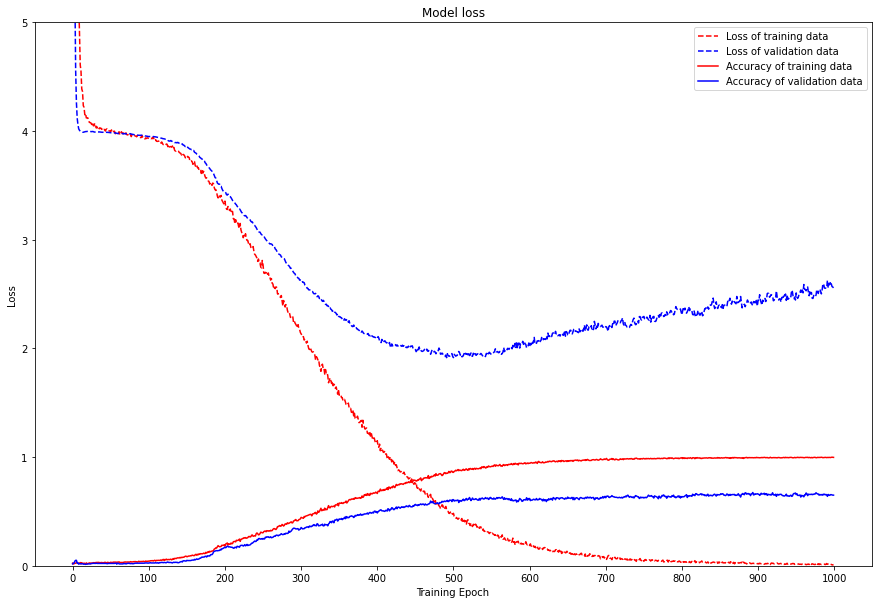

In [12]:
plt.figure(figsize=(15, 10))

plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')


plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Training Epoch')
plt.xticks(range(0, 1001, 100))
plt.yticks(range(0, 6))
plt.ylim(0,5)
plt.legend()
plt.show()

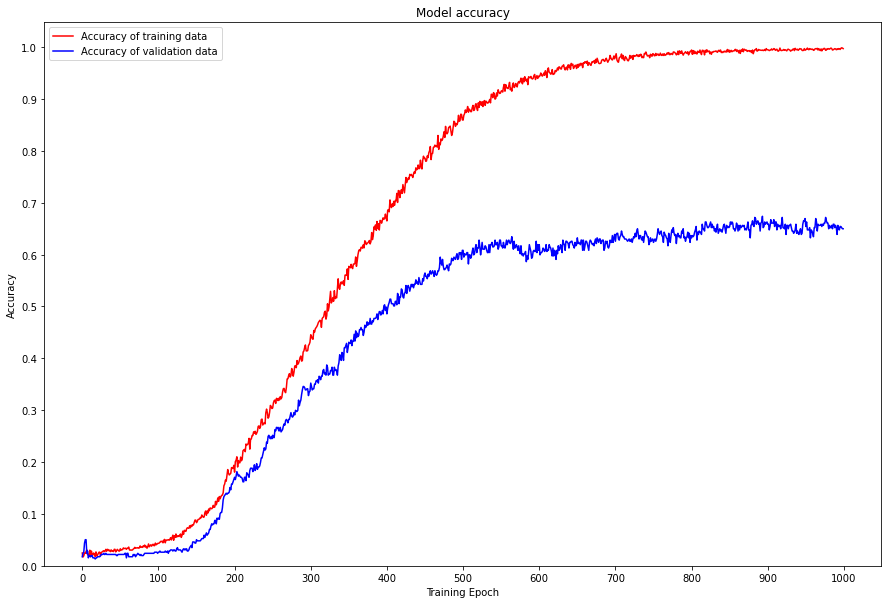

In [13]:
plt.figure(figsize=(15, 10))

plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Training Epoch')
plt.xticks(range(0, 1001, 100))
plt.yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
plt.ylim(0)
plt.legend()
plt.show()

In [14]:
# Print confusion matrix for training data
y_pred_train = model_4.predict(train_features)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
print(train_label.shape, max_y_pred_train.shape, train_features.shape)
print(classification_report(train_label, max_y_pred_train))

(2284,) (2284,) (2284, 21600)
              precision    recall  f1-score   support

           0       0.85      0.98      0.91        41
           1       0.97      0.90      0.94        42
           2       0.95      0.93      0.94        43
           3       0.86      0.90      0.88        42
           4       0.85      0.85      0.85        48
           5       0.93      0.88      0.90        42
           6       0.87      0.95      0.91        42
           7       0.90      0.96      0.93        46
           8       0.91      0.89      0.90        47
           9       0.88      0.70      0.78        20
          10       0.98      0.91      0.94        45
          11       0.91      0.98      0.94        41
          12       0.95      0.97      0.96        40
          13       0.91      0.97      0.94        40
          14       0.97      0.95      0.96        40
          15       0.95      0.98      0.96        42
          16       0.97      0.85      0.91        

In [15]:
model_4.save('model_4.x1000.00001')

INFO:tensorflow:Assets written to: model_4.x1000.00001\assets


I think the effect of increasing loss and accuracy is caused by a network that, at a given epoch, might be severely overfit on some classes but still learning on others.

In [16]:
from keras.utils.vis_utils import plot_model
plot_model(model_4, to_file='model_4_1000epoch_00001lr_55valaccuracy.png', dpi=100, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


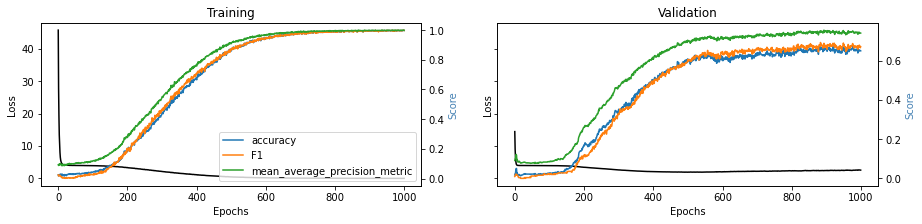

In [17]:
# plot
metrics = [k for k in history.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,3))

## training
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(history.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(history.history[metric], label=metric)
    ax11.set_ylabel("Score", color='steelblue')
ax11.legend()

## validation
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(history.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
    ax22.plot(history.history['val_'+metric], label=metric)
    ax22.set_ylabel("Score", color="steelblue")
plt.show()